## REFERENCES

## GITHUB repos: 
### code
* **Hands-On Machine Learning w/scikit-learn and TensorFlow book: https://github.com/AMDonati/handson-ml**
* **Tristan Deep Dive class**: https://github.com/AMDonati/dsr-apr-2018
* Data viz - Jesus: 
 > http://localhost:8888/notebooks/00_TRAINING/02_DSR/VIZ_course/PLOTLY/code_for_slides.ipynb

### documentation
* https://github.com/AMDonati/handong1587.github.io/blob/master/_posts/deep_learning/2015-10-09-rnn-and-lstm.md
* https://github.com/AMDonati/Deep-Learning-Papers-Reading-Roadmap

### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

### time-series w/ DL
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
* https://github.com/AMDonati/Deep-Learning-in-Time-Series
* https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data

### time-series w/ DL on EHR data
* https://github.com/AMDonati/Deep-Neural-Networks-HealthCare/tree/master/Project%209%20--%20Deep%20Learning%20RNN%20for%20Predicting%20%20Glucose%20Concentration%20for%20Diabetes1%20Patients
* https://github.com/AMDonati/Deep-Neural-Networks-HealthCare/tree/master/Project%209%20--%20Deep%20Learning%20RNN%20for%20Predicting%20%20Glucose%20Concentration%20for%20Diabetes1%20Patients
* https://github.com/AMDonati/doctorai

### Specific to multi-label classification: 
https://github.com/nkartik94/Multi-Label-Text-Classification

## Kaggle Kernels
* https://www.kaggle.com/c/web-traffic-time-series-forecasting
* https://www.kaggle.com/c/melbourne-university-seizure-prediction/kernels
* https://www.kaggle.com/c/msk-redefining-cancer-treatment/kernels

## FRAMEWORK
1. Data-processing
2. Plotting the data
3. Preparing the data for the ML algo:
    * Dimensionality reduction? 
    * Standardization/ normalisation? 
    * split train/val/test
    * do something special for the multi-label classification problem?
4. Select and train the model
5. Model Evaluation: plot the results
    * Fine-tune the model
    * Cross-validation
    * Metrics plotting

## 0. Imports & functions

In [91]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
import seaborn as sns
import urllib.parse
from glob import glob
import os
import ntpath 
import zipfile

#and enable the offline mode in the notebook (not needed in Jupyter Lab)
#py.offline.init_notebook_mode(connected=True)

#paths
#PPMI_zippath='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018.zip'
PPMI_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/'

In [48]:
#!pip install cufflinks --upgrade

In [2]:
def reading_csv_files(folder_path):
    # saving all the csv files in a dataframe
    import os
    import glob
    # glob.glob('*.csv') #find all the csv files in a pathname. 
    os.chdir(folder_path)
    csv_files = [i for i in glob.glob('*.csv')]

    # Reading each csv file and storing them in a dictionnary containing the file name and the dataframe
    dict_files={}
    files_names=[]
    for files in csv_files:
        df=pd.read_csv(files,engine='python')
        basepath, filename=ntpath.split(files)
        files_names.append(filename)
        dict_files[filename]=df
        
    # Calculating the # of rows and features for each dataframe and storing them in a list of tuples
    shape_df=[]
    for i in range(0,len(dict_files.keys())):
        nrows, ncols=(len(dict_files[files_names[i]]),len(dict_files[files_names[i]].columns))
        shape_df.append((nrows,ncols))

    return (shape_df,files_names,dict_files)

In [3]:
def number_of_patients(df):
    '''return the number of patients in each csv files and the number of events'''
    patients=len(list(set(df['PATNO'])))
    if 'EVENT_ID' in df.columns:
        events=len(list(set(df['EVENT_ID'])))
    else:
        events='no TS data'
    return (patients,events)

In [4]:
def features_selection(df, SEL):
    '''cleanier way to do features selection in each csv file'''
    return df_sel

In [5]:
def patients_selection(df, threshold):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        print("There is no 'PATNO' column in the dataframe")

## 1. Data-processing

###  Getting the PD people.


In [6]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Patient_Status - actually useful for selecting only the PD patients in each table
PRODROMA=dict_files[files_names[0]]
#print(number_of_patients(PRODROMA))
#print(list(set(PRODROMA['RECRUITMENT_CAT'])))
#print(list(set(PRODROMA['ENROLL_CAT'])))
PRODROMA.head()
PD_cat=['PD','REGPD','GENPD']
mask=PRODROMA['ENROLL_CAT'].isin(PD_cat)
PD_patients=list(PRODROMA.loc[mask,'PATNO'])
print('number of PD patients:{}'.format(len(PD_patients)))

### Screening__Demographics - useful
#### NOT TS DATA
SCREEN=dict_files[files_names[3]]

SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME',
       'CONSNTDT', 'APPRDX', 'CURRENT_APPRDX', 'P3GRP', 'BIRTHDT', 'GENDER',
       'HISPLAT', 'RAINDALS', 'RAASIAN', 'RABLACK', 'RAHAWOPI', 'RAWHITE',
       'RANOS', 'PRJENRDT']
SCREEN_sel=SCREEN[SEL]
#list(set(SCREEN_sel['EVENT_ID']))
#print(number_of_patients(SCREEN))
SCREEN_sel.head()

number of PD patients:876


,REC_ID,PATNO,EVENT_ID,PAG_NAME,CONSNTDT,APPRDX,CURRENT_APPRDX,P3GRP,BIRTHDT,GENDER,HISPLAT,RAINDALS,RAASIAN,RABLACK,RAHAWOPI,RAWHITE,RANOS,PRJENRDT
0,224392801,3400,CONSENT,SCREEN,06/2010,1.0,1.0,NaN,1971.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,07/2010
1,224394301,3401,CONSENT,SCREEN,06/2010,2.0,2.0,NaN,1954.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,07/2010
2,224398401,3402,CONSENT,SCREEN,06/2010,3.0,3.0,NaN,1964.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10/2011
3,224400201,3403,CONSENT,SCREEN,06/2010,1.0,1.0,NaN,1941.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,07/2010
4,224718101,3404,CONSENT,SCREEN,06/2010,2.0,2.0,NaN,1954.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,07/2010


### Creating the dataset with selected features.

In [8]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Diagnostic_Features.csv': useful: Feat-PD - 1670 patients.
DIAGFEAT=dict_files[files_names[1]]
#DIAGFEAT.head()
#DIAGFEAT.columns

SEL=['REC_ID', 'PATNO', 'EVENT_ID','INFODT',
       'DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM',
       'DFOTHTRM', 'DFTREMCM', 'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG',
       'DFTONE', 'DFOTHRIG', 'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES',
       'DFBRPLUS', 'DFOTHABR', 'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ',
       'DFFALLS', 'DFOTHPG', 'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON',
       'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFDOPRSP', 'DFRAPSPE', 'DFBULBAR', 'DFCTSCAN', 'DFMRI', 'DFATYP']

#using SEL2 for now: removing features with Non applicable values
SEL2=[ 'REC_ID','PATNO', 'EVENT_ID','INFODT',
       'DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM',
       'DFOTHTRM', 'DFTREMCM', 'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG',
       'DFTONE', 'DFOTHRIG', 'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES',
       'DFBRPLUS', 'DFOTHABR', 'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ',
       'DFFALLS', 'DFOTHPG', 'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON',
       'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFRAPSPE', 'DFBULBAR','DFATYP']

#SEL2=SEL.remove('DFCTSCAN')
#SEL2=SEL.remove('DFDOPRSP')
#SEL2=SEL.remove('DFMRI')

#DIAGFEAT_sel_PDpat=DIAGFEAT_sel.loc[DIAGFEAT_sel['PATNO']isin(PD_patients),:]
#print(number_of_patients(DIAGFEAT_sel_PDpat))

# seleting the patients and features
patients_sel=patients_selection(DIAGFEAT,6)[0]
DIAGFEAT_sel=patients_selection(DIAGFEAT,6)[1]
DIAGFEAT_sel=DIAGFEAT_sel[SEL2]
DIAGFEAT_sel.reset_index(drop=True,inplace=True)
DIAGFEAT_sel.head()


,REC_ID,PATNO,EVENT_ID,INFODT,DFSTROKE,DFRSKFCT,DFPRESNT,DFRPROG,DFSTATIC,DFHEMPRK,...,DFPSHYPO,DFSEXDYS,DFURDYS,DFBWLDYS,DFOCULO,DFEYELID,DFNEURAB,DFRAPSPE,DFBULBAR,DFATYP
0,544962901,3051,V12,11/2015,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,378904801,3051,V06,11/2012,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,659585301,3051,V14,10/2017,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,595650601,3051,V13,10/2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,417112701,3051,V08,11/2013,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating the Labels.

In [10]:
### 'Modified_Schwab_+_England_ADL.csv' - 1837 patients

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

MODSEADL=dict_files[files_names[6]]
#print(number_of_patients(MODSEADL))
#MODSEADL.head()
#list(set(MODSEADL['MSEADLG']))

# seleting the patients and features
patients_sel=patients_selection(MODSEADL,6)[0]
MODSEADL_sel=patients_selection(MODSEADL,6)[1]
SEL=['REC_ID','PATNO','EVENT_ID','INFODT','MSEADLG']
MODSEADL_sel=MODSEADL_sel[SEL]

# finding the patient set intersection between features and labels 
labels_pat=patients_selection(MODSEADL,6)[0] 
feat_pat=patients_selection(DIAGFEAT_sel,6)[0]
intersect=list(set(labels_pat) & set(feat_pat)) # ok cool: all the patients in DIAGFEAT are in MODSEADL. 
#print(len(intersect))

# selecting only the intersect patients.
MODSEADL_sel2=MODSEADL_sel.loc[MODSEADL_sel['PATNO'].isin(intersect),:]
print(number_of_patients(MODSEADL_sel2))
#MODSEADL_sel2.reset_index(drop=True,inplace=True)
MODSEADL_sel2.head()


(320, 18)


,REC_ID,PATNO,EVENT_ID,INFODT,MSEADLG
506,320322201,3051,V04,11/2011,95.0
4405,478012101,3051,V10,11/2014,80.0
3626,436854001,3051,V09,04/2014,85.0
956,346352601,3051,V05,05/2012,95.0
3039,417119301,3051,V08,11/2013,85.0


In [80]:
# merging features & label for plotting: 
#MODSEADL_sel2=MODSEADL_sel.loc[intersect,:]
diagfeat_EADL=pd.merge(DIAGFEAT_sel,MODSEADL_sel2,on=['PATNO','EVENT_ID','INFODT'],how='left')
diagfeat_EADL.head()

,REC_ID_x,PATNO,EVENT_ID,INFODT,DFSTROKE,DFRSKFCT,DFPRESNT,DFRPROG,DFSTATIC,DFHEMPRK,...,DFURDYS,DFBWLDYS,DFOCULO,DFEYELID,DFNEURAB,DFRAPSPE,DFBULBAR,DFATYP,REC_ID_y,MSEADLG
0,544962901,3051,V12,11/2015,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,544964201.0,75.0
1,378904801,3051,V06,11/2012,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,378915401.0,95.0
2,659585301,3051,V14,10/2017,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,659589001.0,90.0
3,595650601,3051,V13,10/2016,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,595656701.0,80.0
4,417112701,3051,V08,11/2013,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,417119301.0,85.0


## 2-Plotting. 

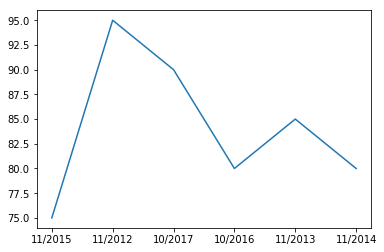

In [69]:
df_3051=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==3051,:]
plt.plot(df_3051['INFODT'], df_3051['MSEADLG'])
plt.show()

In [84]:
import cufflinks as cf
# Configure it to work offline:
cf.go_offline(connected=True)

df_3051=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==3051,:]
df_3051.set_index('INFODT',inplace=True)
df_3051['var_sumfeat']=df_3051.iloc[:,range(3,54)].sum(axis=1)
df_3051_sumfeat=df_3051.loc[:,'var_sumfeat']
df_3051_plot=df_3051.iloc[:,range(3,54)]

df_3051_plot.iplot(kind='scatter',filename='PATNO 3051 Diag Feat over time')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [87]:
df_3051_sumfeat.iplot(kind='scatter',filename='PATNO 3051 Diag Feat over time')
#df_3051_sumfeat

In [101]:
# Plotting the labels of multiple patients
np.random.seed(123)
sample_10=list(np.random.randint(0,number_of_patients(diagfeat_EADL)[0],10))
patients_sample=pd.Series(list(set(diagfeat_EADL['PATNO'])))[sample_10]
patients_sample=list(patients_sample.values)

[40603, 3432, 3111, 42121, 40611, 41664, 60004, 50509, 40800, 40601]

In [128]:
#patients_labels_samples=diagfeat_EADL.loc[diagfeat_EADL['PATNO'].isin(patients_sample),['PATNO','INFODT','MSEADLG']]
#patients_labels_samples.dropna(inplace=True)

#plotting with plotly 
import plotly as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#Traces
data=[]
for i in patients_sample: 
    sub_df=diagfeat_EADL.loc[diagfeat_EADL['PATNO']==i,:]
    sub_df.dropna(inplace=True)
    #trace=dict(type='scatter',x=sub_df['INFODT'],
              # y=sub_df['MSEADLG'],
              # name='PATNO{}'.format(i))
    trace=go.Scatter(x=sub_df['INFODT'],y=sub_df['MSEADLG'],name='PATNO{}'.format(i))
    data.append(trace)
#Figure
#fig=go.Figure(data)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Code from F.Chollet on temperatures forecast - to adapt to my problem

## 3-Preparing the data for the RNN

### Normalization
`mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std`

In [123]:
## implementing generator
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
### train/val/test split
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 4- Training w/ baselines. 

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()


#### simple NN: 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 4-Training w a RNN

### first RNN. 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
#### plotting results

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### adding dropout layers to prevent overfitting

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#### plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### stacking more layers

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#### plotting the results. 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## TO USE LATER ON (multi-label classification)

In [ ]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'MDS_UPDRS_Part_I.csv' - 2010 patients

NUPDRS1=dict_files[files_names[2]]
print(number_of_patients(NUPDRS1))
NUPDRS1.head()

### 'MDS_UPDRS_Part_III.csv' - 2010 patients

NUPDRS3=dict_files[files_names[7]]
print(number_of_patients(NUPDRS3))
NUPDRS3.head()

In [ ]:
### 'General_Neurological_Exam.csv': useful: Feat-Gen - 2048 patients

PENEURO=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'MSRARSP', 'MSRACM', 'MSLARSP', 'MSLACM', 'MSRLRSP', 'MSRLCM',
       'MSLLRSP', 'MSLLCM', 'COFNRRSP', 'COFNRCM', 'COFNLRSP', 'COFNLCM',
       'COHSRRSP', 'COHSRCM', 'COHSLRSP', 'COHSLCM', 'SENRARSP', 'SENRACM',
       'SENLARSP', 'SENLACM', 'SENRLRSP', 'SENRLCM', 'SENLLRSP', 'SENLLCM',
       'RFLRARSP', 'RFLRACM', 'RFLLARSP', 'RFLLACM', 'RFLRLRSP', 'RFLRLCM',
       'RFLLLRSP', 'RFLLLCM', 'PLRRRSP', 'PLRRCM', 'PLRLRSP', 'PLRLCM']
print(number_of_patients(PENEURO))
PENEURO_sel=PENEURO[SEL]
PENEURO_sel.head()
#list(set(PENEURO['EVENT_ID']))

### 'Neurological_Exam_-_Cranial_Nerves.csv': useful: Feat-PD - 2049 patients

PENEURO2=dict_files[files_names[13]]
PENEURO2.head()
PENEURO2.columns

SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'CN1RSP','CN2RSP', 'CN346RSP','CN5RSP',
     'CN7RSP', 'CN8RSP', 'CN910RSP',
       'CN11RSP', 'CN12RSP']
print(number_of_patients(PENEURO2))
PENEURO2_sel=PENEURO2[SEL]
PENEURO2_sel.head()
#list(set(PENEURO['EVENT_ID']))

In [ ]:
### 'Vital_Signs.csv': useful: Feat-Gen
### 2047 patients

VITAL=dict_files[files_names[15]]
#VITAL.head()
#VITAL.columns

SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'WGTKG', 'HTCM', 'TEMPC', 'SYSSUP', 'DIASUP', 'HRSUP',
       'SYSSTND', 'DIASTND', 'HRSTND']
print(number_of_patients(VITAL))
VITAL_sel=VITAL[SEL]
VITAL_sel.head()

## GARBAGE. 

In [ ]:
## 3-Enrollment 

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/3-Enrollment/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Primary_Diagnosis.csv' - useful: Feat-Gen - 789 patients... 
### 54% of them are PD patients.

### 'Primary_Diagnosis.csv' - useful: Feat-Gen
PRIMDXPD=dict_files[files_names[8]]
#PRIMDXPD.head()
#PRIMDXPD.columns

SEL=['REC_ID', 'F_STATUS', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'PRIMDIAG', 'OTHNEURO']
print(number_of_patients(PRIMDXPD))
PRIMDXPD_sel=PRIMDXPD[SEL]
#list(set(PRIMDXPD['EVENT_ID']))
print(list(set(PRIMDXPD_sel['PRIMDIAG'])))
PRIMDXPD_sel.head()
patients_PRIMDXPD=list(set(PRIMDXPD['PATNO']))
mask_PD=pd.Series(patients_PRIMDXPD).isin(PD_patients)
np.average(mask_PD)